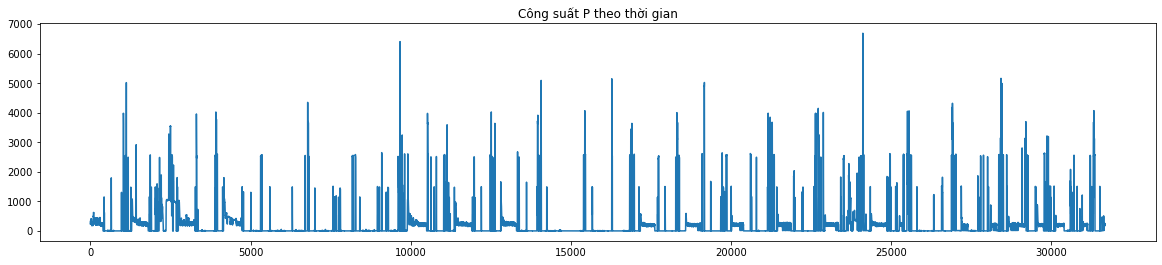

num data point = 31679
(31679, 6)
(31679, 3)


In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 4)

# ----------READ DATA-------------
# Power dataframe
p_df = pd.read_csv('./data/W.csv',
                   names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                   header=0)
# Voltage dataframe
u_df = pd.read_csv('./data/V.csv',
                   names=['time', 'u'],
                   header=0)
# Current dataframe
i_df = pd.read_csv('./data/A.csv',
                   names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                   header=0)
# Power factor dataframe
pf_df = pd.read_csv('./data/cosphi.csv',
                    names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                    header=0)

# Reactive power dataframe
q_df = pd.DataFrame()
q_df['time'] = p_df['time']
column_names = ['light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker']

# Calculate reactive power using P and cosphi
for col_name in column_names:
    q_df[col_name] = np.tan(np.arccos(pf_df[col_name])) * p_df[col_name]

select_device = ['heater', 'indcooker', 'aircond1']

p_sum = p_df[select_device].sum(axis=1).to_numpy()
q_sum = q_df[select_device].sum(axis=1).to_numpy()
u_sum = u_df['u'].to_numpy()  # không cần tính tổng U, nhưng cứ đặt là u_sum cho đồng nhất
i_sum = i_df[select_device].sum(axis=1).to_numpy() * 100  # Nhân với 100 để I không quá nhỏ

plt.title("Công suất P theo thời gian")
plt.plot(p_sum)
plt.show()

# -----------------PREPARE DATA-------------------
data = []
label = []
threshold = 20  # ngưỡng xác định thiết bị là bật > 20W
for i in range(1, len(p_sum)):
    delta_p = p_sum[i] - p_sum[i - 1]
    delta_q = q_sum[i] - q_sum[i - 1]
    data.append([u_sum[i], i_sum[i], p_sum[i], q_sum[i], delta_p, delta_q])
    x = 0
    for j, device_name in enumerate(select_device):
        if p_df[device_name].iloc[i] > threshold:
            x += 2 ** j

    label.append(x)

print("num data point =", len(data))


def tobase2(n):
    length = len(select_device)
    ret = [0 for i in range(length)]
    i = length - 1
    while n > 0:
        ret[i] = n % 2
        n = n // 2
        i -= 1
    return ret


X = np.array(data)
y = np.array([tobase2(label[i]) for i in range(len(label))])

print(X.shape)
print(y.shape)




In [217]:
import numpy as np
from math import exp
from scipy.special import xlogy
from scipy.special import expit as logistic_sigmoid
np.random.seed(0)

def sigmoid(x):
    return logistic_sigmoid(x)


def sigmoid_deriv(x):
    sm = sigmoid(x)
    return sm * (1 - sm)


def relu(x):
    return np.maximum(0, x)


def relu_deriv(x):
    return 1 if x > 0 else 0


def tanh(x):
    return np.tanh(x)


def tanh_deriv(x):
    return 1 - np.exp2(tanh(x))


def binary_log_loss(y_true, y_prob):
    eps = np.finfo(y_prob.dtype).eps
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -(xlogy(y_true, y_prob).sum() +
             xlogy(1 - y_true, 1 - y_prob).sum()) / y_prob.shape[0]

class MLPClassifier():
    def __init__(self):
        pass

    def fit(self, X, y):
        n_sample, n_feature = X.shape

        n_input_unit = n_feature
        n_hidden_unit = 30
        n_output_unit = y.shape[1]

        W1 = np.random.uniform(-1 / n_hidden_unit, 1 / n_hidden_unit, (n_hidden_unit, n_input_unit))
        W2 = np.random.uniform(-1 / n_output_unit, 1 / n_output_unit, (n_output_unit, n_hidden_unit))
        b1 = np.zeros((n_hidden_unit, 1))
        b2 = np.zeros((n_output_unit, 1))

        learning_rate = 0.01
        hidden_activation_func = tanh
        hidden_activation_deriv = tanh_deriv
        output_activation_func = sigmoid
        
        max_iter = 100
        
        for it in range(max_iter):
            print("iteration=", it)
            A = np.zeros((3, n_sample))  # activations
            A = [X] + [None] + [None]
            
            # forward pass
            Z1 = np.dot(W1, X.T) + b1
            A[1] = hidden_activation_func(Z1)
            Z2 = np.dot(W2, A[1]) + b2
            A[2] = output_activation_func(Z2)

            # compute loss (cross entropy or log loss)
            log_loss = binary_log_loss(y, A[2].T)
            print(f'{log_loss=}')

            # backpropagation
            dZ2 = A[2] - y.T
            dW2 = np.dot(dZ2, A[1].T) / n_sample
            db2 = np.sum(dZ2, axis=1, keepdims=True) / n_sample
            dZ1 = np.multiply(np.dot(W2.T, dZ2), hidden_activation_deriv(Z1))
            dW1 = np.dot(dZ1, X)
            db1 = np.sum(dZ1, axis=1, keepdims=True) / n_sample
            
            # update params
            W1 = W1 - learning_rate * dW1
            W2 = W2 - learning_rate * dW2
            b1 = b1 - learning_rate * db1
            b2 = b2 - learning_rate * db2
            
        print("End training")
        self.n_input_unit_ = n_input_unit
        self.n_hidden_unit_ = n_hidden_unit
        self.n_output_unit_ = n_output_unit
        self.W1_ = W1
        self.W2_ = W2
        self.b1_ = b1
        self.b2_ = b2
        
    def predict(self, X):
        W1 = self.W1_
        W2 = self.W2_
        b1 = self.b1_
        b2 = self.b2_
        
        Z1 = np.dot(W1, X.T) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(W2, A1) + b2
        A2 = sigmoid(Z2)
        
        ret = A2.T
        ret[ret >= 0.5] = 1
        ret[ret < 0.5] = 0
        return ret.astype(int)
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        result = (y_pred == y_test).all(axis=1)
        return result[result==True].shape[0] / y_test.shape[0]

In [218]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=False)

In [219]:
model = MLPClassifier()
model.fit(X_train, y_train)

iteration= 0
log_loss=3.6137615311583753
iteration= 1
log_loss=3.041856621633706
iteration= 2
log_loss=9.703020054761264
iteration= 3
log_loss=2.0672877809730372
iteration= 4
log_loss=3.7700376228638084
iteration= 5
log_loss=2.792847754478223
iteration= 6
log_loss=7.576709024691597
iteration= 7
log_loss=2.6708295921783485
iteration= 8
log_loss=7.191747757917142
iteration= 9
log_loss=3.946756810127413
iteration= 10
log_loss=7.928934518606865
iteration= 11
log_loss=8.260025815018146
iteration= 12
log_loss=3.29953073843254
iteration= 13
log_loss=7.172873161232962
iteration= 14
log_loss=6.4637380852722
iteration= 15
log_loss=7.887835148782712
iteration= 16
log_loss=7.853802949952971
iteration= 17
log_loss=4.4878246600846055
iteration= 18
log_loss=7.4311391019939395
iteration= 19
log_loss=4.694845317216743
iteration= 20
log_loss=4.0771352119084145
iteration= 21
log_loss=6.665224991135522
iteration= 22
log_loss=5.133102201870724
iteration= 23
log_loss=3.8430035435063834
iteration= 24
log_los

In [220]:
output = model.predict(X_test)

In [221]:
output

array([[0, 0, 0],
       [0, 0, 0],
       [1, 1, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [222]:
np.unique(output, axis=0)

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0]])

In [223]:
np.unique(y_test, axis=0)

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [224]:
model.score(X_test, y_test)

0.4866372053872054

In [225]:
model.score(X_train, y_train)

0.5191882750845547

In [226]:
model.W2_

array([[-0.69123221,  0.04311384,  0.28094638, -0.56360821,  0.63278618,
         0.09583062,  0.16707134, -0.00504861,  0.49650843, -0.29823186,
        -0.06092578, -0.54047484, -0.60798117,  0.73119173,  0.4170253 ,
        -0.14334886, -0.49862036, -0.23124042, -0.90067967, -0.11256896,
        -0.4409449 ,  0.18873542, -0.16520739, -0.53829149, -0.79054925,
        -0.88365112,  0.12891769,  0.08633226, -0.10143445,  0.5731503 ],
       [ 0.7727521 , -0.36219782,  0.65918823, -0.33328864, -0.74848515,
         0.18008918, -0.26798349, -0.04831092, -0.02774205,  0.81544295,
        -0.01915116,  0.91854127, -0.24279288,  0.28444559, -0.89787877,
         0.55382351,  0.55356227, -0.73166931,  0.68405546,  0.14535925,
        -0.30430422, -0.34905425, -0.02241482, -1.11229392, -0.73411405,
        -0.35673081, -0.0937524 , -0.26472955, -0.23618437, -0.08201017],
       [ 0.42168014, -0.54135462,  0.22582356, -0.57433929,  0.59021478,
        -0.40962785,  0.15304563, -0.42581336, -0

In [227]:
model.W1_

array([[ 1.78432479e+06,  7.58461728e+05,  8.59824348e+05,
         7.86710036e+15,  6.66190362e+04,  1.16236361e+16],
       [ 5.88756731e+05,  4.60032067e+05,  8.22073222e+05,
        -2.23084092e+12,  2.34639776e+03,  3.95505315e+13],
       [-5.26020424e+05, -2.08181935e+05, -3.25058237e+05,
        -5.73118519e+14,  2.11122596e+04,  1.57017525e+15],
       [-2.88520752e+03,  2.30364779e+04,  6.59781295e+04,
        -2.77958362e+14,  7.62574302e+03, -1.59322873e+13],
       [ 1.02683411e+06,  6.31784818e+05,  1.07896148e+06,
         1.25031789e+13,  5.85827865e+03,  1.37996430e+13],
       [ 3.56906535e+05,  2.57368834e+05,  5.10954698e+05,
         9.98979526e+14,  2.77557914e+03, -9.86408869e+14],
       [-4.81382337e+04, -4.50546539e+03, -8.92519125e+02,
        -1.49768379e+13,  2.81258094e+03,  2.02462909e+13],
       [ 3.23238564e+05,  2.63876096e+05,  4.76758154e+05,
         7.96154308e+12,  7.44543282e+03,  1.36102850e+13],
       [-4.54316481e+05,  1.58722121e+05,  5.901